### Full Name : mohamad moeen samadi azad
### Student Number : 400105093
___

# Problem
<b>In this project, you are free to use PyTorch; you don't have to use just NumPy.</b>
<br>
<br>
In this project, you need to implement the Forward-Forward algorithm. The Forward-Forward (FF) approach is a learning algorithm proposed as an alternative to traditional backpropagation in training neural networks.
<br>
Unlike traditional methods which involve both forward and backward passes (backpropagation), the Forward-Forward approach only involves forward passes through the network. This means the network updates its weights and biases based on forward computations without the need for gradient-based optimization.
<br>
Training data is split into "positive" and "negative" examples.
Positive data consists of typical input-output pairs from the dataset.
Negative data can be generated in various ways, such as random noise or incorrect labels paired with inputs.
The goal is for the network to distinguish between these positive and negative examples.
<br>
Each layer in the neural network learns independently, adjusting its parameters to increase the likelihood of correctly identifying positive and negative examples.
This approach reduces the dependencies between layers seen in backpropagation where gradients need to flow backward through the entire network.
<br>
<br>
If you want to know more about this algorithm, read <a href="https://arxiv.org/pdf/2212.13345">this paper</a>.

# Setup

In [1]:
#####################################################################################
#  You can add other packages but your final implementation should be with pytorch  #
#####################################################################################

import torch
import torchvision
from torchvision.datasets import MNIST
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm



device = 'cuda'

# Section 1: Data (12 Points)

## Download (2 Points)

Download MNIST data (train and test) (2 Points).

In [2]:
#####################################################
##                 Download Data                   ##
####################[Your Code]######################
transform = torchvision.transforms.Compose( 
    [
        torchvision.transforms.ToTensor(),
                
    ]
)
train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)




Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11751532.41it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 345590.51it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3248079.18it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1249542.75it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Negative Sample (5 Points)

As you understand, we need to generate false samples. To do this, we first need to find a false label for each sample. Therefore, create a vector the size of the targets but with a false label for each sample.

In [3]:
def get_false_targets(targets, number_of_classes=10):
    """
    Generate false targets for a given set of true targets.

    This function creates a set of false targets by ensuring that each false target
    is different from the corresponding true target. The false targets are generated
    by randomly selecting from a specified number of classes.

    Parameters:
    -----------
    targets : torch.Tensor
        A 1-dimensional tensor containing the true target labels. Each value in the tensor
        should be an integer representing the class label of the corresponding sample.

    number_of_classes : int, optional, default=10
        The total number of classes from which to generate the false targets. This defines the
        range [0, number_of_classes - 1] from which random class labels are sampled.

    Returns:
    --------
    false_targets : torch.Tensor
        A 1-dimensional tensor of the same shape as `targets`, containing the generated false
        targets. Each value in this tensor is different from the corresponding value in `targets`.

    Notes:
    ------
    - The function generates an initial set of random targets from the specified number of classes.
    - For each target in the input, it ensures the false target is different from the true target
      by repeatedly sampling a new random target until it is different.

    Example:
    --------
    >>> import torch
    >>> targets = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    >>> false_targets = get_false_targets(targets, number_of_classes=10)
    Generating false targets...
    >>> print(false_targets)
    tensor([1, 0, 3, 4, 5, 6, 7, 8, 9, 0])  # Example output, actual results will vary

    """
    #####################################################
    ##              Genrate false data                 ##
    ####################[Your Code]######################
    false_targets = torch.randint(0, number_of_classes, targets.shape).to(device)
    false_targets = torch.where(false_targets == targets, (false_targets + 1) % number_of_classes, false_targets)
    return false_targets




## Overlay Label (5 Points)

The "Overlay Label" step in the Forward-Forward (FF) algorithm refers to a technique used to help the network differentiate between positive (real) and negative (false) samples by embedding additional information into the input data. You can do this as follows:
<br>
For each input vector, set the first 10 elements to zero, and then set the corresponding label (which can be the true label or the false label) to one.

In [4]:
def overlay_label(data, target, classes=10):
    """
    Overlay labels onto input data vectors.

    This function modifies the input data vectors by zeroing out the first `classes`
    elements in each vector and setting the element corresponding to the target label to 1.
    This effectively encodes the target labels within the data vectors.

    Parameters:
    -----------
    data : torch.Tensor
        A 2-dimensional tensor where each row represents a data sample and each column
        represents a feature. The shape of the tensor should be (number of samples, number of features).

    target : torch.Tensor
        A 1-dimensional tensor containing the target labels for each data sample. Each value
        in the tensor should be an integer representing the class label of the corresponding sample.

    classes : int, optional, default=10
        The number of classes in the dataset. This determines how many elements in each data
        vector will be used to overlay the labels. The function will zero out the first `classes`
        elements and set one of them to 1 according to the target label.

    Returns:
    --------
    overlayed_data : torch.Tensor
        A 2-dimensional tensor of the same shape as `data`, with the labels overlaid. The first
        `classes` elements of each data vector are modified to encode the target label.

    Example:
    --------
    >>> import torch
    >>> data = torch.randn(5, 20)  # Example data with 5 samples and 20 features
    >>> target = torch.tensor([0, 1, 2, 3, 4])  # Example target labels
    >>> overlayed_data = overlay_label(data, target, classes=10)
    >>> print(overlayed_data)
    tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, ...],
            [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, ...],
            [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, ...],
            [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, ...],
            [0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, ...]])
    # The actual output will vary because the initial data is randomly generated.
    """
    #####################################################
    ##              Overlay false data                 ##
    ####################[Your Code]######################
    overlayed_data = data.clone()
    overlayed_data[:, :classes] = 0
    overlayed_data[torch.arange(overlayed_data.shape[0]), target] = 1

    return overlayed_data
    



    

# Section 2: Supervised FF (48 Points)

## Layer (18 Points)

Now you should create a custom Layer and it is a little different from normal Layers in pytorch. In the __init__ method, first, set up a fully connected linear layer to transform input features to output features. Then, create an optimizer with a learning rate to update parameters during training. Also, define a threshold value to assist in the loss function, distinguishing between positive and negative samples. Lastly, set the number of epochs for training.
<br>
Next, in the forward method, you'll handle the forward pass through the network. Normalize the input vectors. Pass the normalized inputs through the fully connected linear layer. Finally, apply a ReLU activation function to introduce non-linearity.
<br>
Now, in the train method, you'll implement the core training logic. This method takes two arguments: x_pos (positive samples) and x_neg (negative samples). Iterate over a predefined number of epochs. In each epoch, compute the squared mean of the outputs for both positive and negative samples. These values will help calculate the loss, which encourages lower energy for positive samples and higher energy for negative ones. Then use your optimizer and loss and display the current loss. After training completes, return the transformed positive and negative samples.

In [5]:
class Layer(torch.nn.Linear):
    """
    A custom linear layer with normalization, ReLU activation, and an integrated training loop.

    This class defines a single linear layer with additional functionality for normalization
    and ReLU activation. It also includes methods for training the layer using a custom
    objective function in the context of the forward-forward algorithm.

    Parameters:
    -----------
    in_features : int
        The number of input features to the linear layer.
    out_features : int
        The number of output features from the linear layer.

    Attributes:
    -----------
    fc : torch.nn.Linear
        The linear layer that performs the transformation.
    opt : torch.optim.Adam
        The Adam optimizer for training the linear layer.
    threshold : float
        The threshold used in the custom loss function.
    num_epochs : int
        The number of epochs to run during training.

    Methods:
    --------
    forward(x):
        Forward pass through the layer. Normalizes the input, applies the linear transformation,
        and then applies the ReLU activation.

    train(x_pos, x_neg):
        Trains the layer using positive and negative samples. The training loop runs for a
        specified number of epochs and optimizes a custom loss function based on the forward-forward
        algorithm.

    Notes:
    ------
    - The `forward` method normalizes the input vectors to unit norm before applying the linear layer.
    - The `train` method uses a custom loss function that encourages the activations for positive samples
      to be above a threshold and for negative samples to be below the threshold.
    - The loss function is computed using `torch.log1p(torch.exp(...))` for numerical stability.

    """
    def __init__(self, in_features, out_features, bias=True,  dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = torch.optim.Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0
        self.num_epochs = 1000



    def forward(self, x):
        #####################################################
        ##             Implement forward part              ##
        ####################[Your Code]######################
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(
            torch.mm(x_direction, self.weight.T) +
            self.bias.unsqueeze(0))


    def train(self, x_pos, x_neg):
        """
        Train the layer using positive and negative samples.

        Parameters:
        -----------
        x_pos : torch.Tensor
            The positive samples for training. Each row is a sample with `in_features` dimensions.
        x_neg : torch.Tensor
            The negative samples for training. Each row is a sample with `in_features` dimensions.

        Returns:
        --------
        torch.Tensor, torch.Tensor
            The activations of the positive and negative samples after training, with ReLU applied.

        """
        #####################################################
        ##               Train Layer object                ##
        ####################[Your Code]######################
        for i in tqdm(range(self.num_epochs)):
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            # The following loss pushes pos (neg) samples to
            # values larger (smaller) than the self.threshold.
            loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()
            self.opt.zero_grad()
            # this backward just compute the derivative and hence
            # is not considered backpropagation.
            loss.backward()
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()  

        

## Supervised Network (18 Points)

This code defines a supervised neural network called SupervisedNet. This network consists of multiple layers, each defined by the Layer class previously created. The SupervisedNet initializes these layers based on the provided dimensions (dims). Each layer is connected to the next in sequence, forming a deep neural network architecture.
<br>
The train method is responsible for training the network. It iterates over a predefined number of epochs. For each epoch, the method generates false targets for the positive samples. It then modifies both positive and negative samples using the overlay label technique. After that, it iterates through each layer in the network and trains them using the train method of the Layer class.
<br>
In the predict method, the network makes predictions based on input data x. For each possible label (from 0 to 9 in this case), the input is modified using an overlay label technique, and the resulting "goodness" of the input for each label is computed through the layers. The label with the highest goodness is chosen as the predicted label.

In [6]:
class SupervisedNet(torch.nn.Module):
    """
    A supervised neural network for classification using a custom Layer class and forward-forward algorithm.

    This class defines a multi-layer neural network for supervised learning tasks. The network is composed of
    multiple custom linear layers, each using normalization, ReLU activation, and a custom training procedure
    based on the forward-forward algorithm. The network predicts class labels for input samples and is trained
    using both positive and negative samples.

    Parameters:
    -----------
    dims : list of int
        A list specifying the dimensions of each layer in the network. The length of the list determines
        the number of layers, and each element specifies the number of units in that layer.

    Attributes:
    -----------
    layers : list of Layer
        A list containing the layers of the network, each an instance of the custom Layer class.
    num_epochs : int
        The number of epochs to run during training.

    Methods:
    --------
    predict(x):
        Predict the class labels for input data `x`.

    train(x_pos, y):
        Train the network using positive samples `x_pos` and their corresponding labels `y`.

    """
    def __init__(self, dims):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1]).to(device)]

        

    def predict(self, x):
        """
        Predict class labels for the input data.

        Parameters:
        -----------
        x : torch.Tensor
            The input data tensor.

        Returns:
        --------
        torch.Tensor
            A 1-dimensional tensor containing the predicted class labels for each input sample.

        """
        goodness_per_label = []
        for label in range(10):
            h = overlay_label(x, label)
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [h.pow(2).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)


    def train(self, x_pos, x_neg):
        """
        Train the network using positive samples and their corresponding labels.

        Parameters:
        -----------
        x_pos : torch.Tensor
            The positive samples for training.
        y : torch.Tensor
            A 1-dimensional tensor containing the true labels for the positive samples.

        """
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)
        

## Train (6 Points)

Now, define the supervised network, prepare the input data, and train the model.

In [7]:
#####################################################
##       Prepare data and train the model          ##
####################[Your Code]######################
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20000, shuffle=True)
model = SupervisedNet([28*28,1000,1000]).to(device)
x, y = next(iter(train_loader))
x = x.view(x.shape[0], -1)
x, y = x.to(device), y.to(device)
x_pos = overlay_label(x, y)
x_neg = overlay_label(x, get_false_targets(y))


model.train(x_pos, x_neg)

print('train acc:', model.predict(x).eq(y).float().mean().item())



training layer 0 ...


  0%|          | 0/1000 [00:00<?, ?it/s]

training layer 1 ...


  0%|          | 0/1000 [00:00<?, ?it/s]

train acc: 0.9185999631881714


## Metrics and Confusion Matrix (6 Points)

Now, prepare the test data and utilize the predict method to predict the label for each test sample. Then, you can use ready-made methods from sklearn or any other library to print and plot metrics, as well as the confusion matrix.

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1976
           1       0.93      0.98      0.95      2198
           2       0.93      0.88      0.90      2003
           3       0.90      0.89      0.89      1994
           4       0.89      0.91      0.90      1940
           5       0.91      0.85      0.88      1796
           6       0.94      0.94      0.94      2021
           7       0.93      0.91      0.92      2064
           8       0.86      0.89      0.88      1951
           9       0.86      0.87      0.87      2057

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



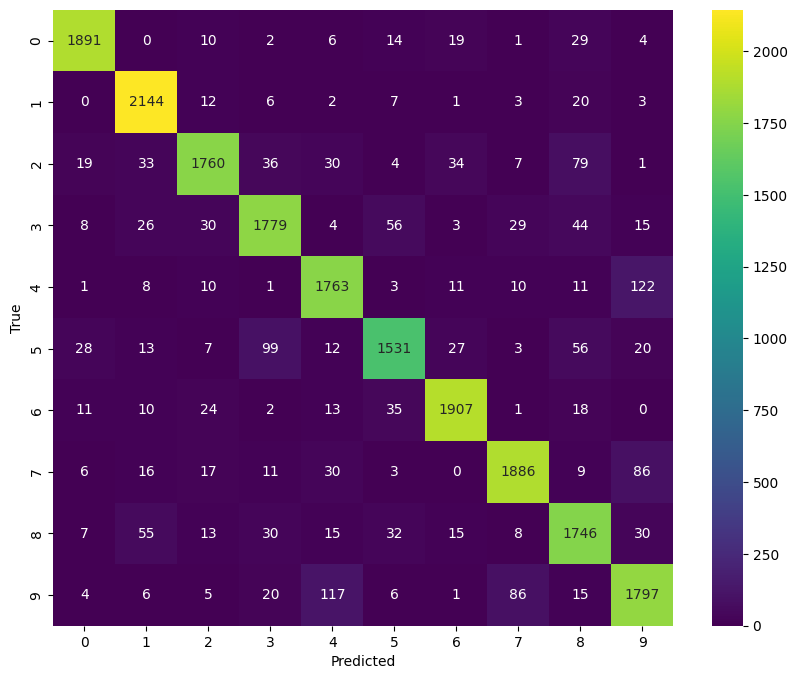

In [8]:
#####################################################
##  Calculate metrics and plot confusion matrix    ##
####################[Your Code]######################

x, y = next(iter(train_loader))
x = x.view(x.shape[0], -1)
x, y = x.to(device), y.to(device)
y_true = y.cpu().numpy()
y_pred = model.predict(x).cpu().numpy()
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()





# Section 2: Unsupervised FF (40 Points)

## Negative Data Without Labels (15 Points)

These helper functions are used in the UnsupervisedNet class to generate false data for training. The get_blur_mask function generates a blur mask, which is a random binary mask used to blend two input samples together. This mask is created by convolving a randomly generated binary tensor with a predefined filter. The resulting mask is used to blend two input samples together by selecting pixels from each sample based on the mask.
<br>
The generate_false_data function generates false data by blending pairs of input samples together using the blur mask generated by the get_blur_mask function. It takes the original input data as input and returns a new tensor containing the blended samples. During the blending process, pairs of input samples are selected randomly, and their pixels are blended together using the blur mask. This process creates distorted versions of the input data, which can be used as negative samples during training.

In [9]:
def get_blur_mask(shape):
    """
    Generate a blurred binary mask for mixing data samples.

    This function creates a binary mask with the same shape as the input data. The mask is generated by
    first creating a random binary mask and then applying a convolution with a smoothing filter to blur the mask.

    Parameters:
    -----------
    shape : tuple
        The shape of the mask to be generated. Typically, this should match the shape of the data samples
        along the feature dimensions.

    Returns:
    --------
    torch.Tensor
        A binary mask tensor with the specified shape, blurred using a 1D convolution.

    Notes:
    ------
    - The mask is created by sampling random binary values (0 or 1) and then applying a 1D convolution with
      a filter `[0.25, 0.5, 0.25]` to smooth the mask.
    - The mask is rounded to the nearest integer (0 or 1) after blurring to ensure it remains binary.
    - The mask is used to blend two different data samples in the `generate_false_data` function.

    """
    #####################################################
    ##               Generate blur mask                ##
    ####################[Your Code]######################
    mask = torch.randint(2, (shape,)).float().to(device)
    mask = torch.nn.functional.conv1d(mask.unsqueeze(0).unsqueeze(0), torch.tensor([0.25, 0.5, 0.25]).unsqueeze(0).unsqueeze(0).to(device), padding=1)
    mask = torch.round(mask)
    return mask.squeeze(0).squeeze(0)


    

def generate_false_data(data):
    """
    Generate false data samples by mixing pairs of real data samples.

    This function creates false data samples by randomly selecting pairs of real data samples and blending
    them using a blurred binary mask. The resulting false data samples retain the structure of the original
    data but with altered feature values.

    Parameters:
    -----------
    data : torch.Tensor
        A 2-dimensional tensor where each row represents a data sample. The shape of the tensor should be
        (number of samples, number of features).

    Returns:
    --------
    torch.Tensor
        A tensor of the same shape as `data`, containing the generated false data samples.

    Notes:
    ------
    - The function generates a random permutation of indices to select pairs of data samples for blending.
    - A blurred binary mask is generated using the `get_blur_mask` function, which is used to combine pairs
      of data samples.
    - Each false data sample is created by taking a weighted combination of two randomly selected samples
      using the mask.

    """
    #####################################################
    ##              Generate false data                ##
    ####################[Your Code]######################
    indices = torch.randint(data.shape[0],(2*data.shape[0],))
    mask = get_blur_mask(data.shape[1])
    false_data = [mask * data[indices[i]] + (1 - mask) * data[indices[i+1]] for i in range(data.shape[0])]
    false_data_tensor = torch.stack(false_data)
    t = false_data_tensor.to(device)
    
    return t


    

## Unsupervised Network (18 Points)

This code defines an unsupervised neural network called UnsupervisedNet. Similar to the supervised version, this network consists of multiple layers, each defined by the Layer class. The UnsupervisedNet initializes these layers based on the provided dimensions (dims), and it also includes a fully connected output layer.
<br>
In the train_fc method, the fully connected output layer is trained using the provided input data and target labels. The input data passes through all layers of the network, and the output of the last layer is used as input to the fully connected layer. The loss is computed using the cross-entropy loss function, and the parameters of the fully connected layer are updated using the optimizer.
<br>
The train method is responsible for training the entire network. It iterates over the provided positive samples and corresponding negative samples. For each pair of positive and negative samples, the method iterates through each layer in the network and trains them using the train method of the Layer class.
<br>
The predict method is used to make predictions based on input data x. The input data passes through all layers of the network, and the output of the last layer is used as input to the fully connected output layer. The predicted labels are obtained by selecting the class with the highest probability from the output of the fully connected layer.

In [10]:
class UnsupervisedNet(torch.nn.Module):
    """
    An unsupervised neural network for training using the forward-forward algorithm without labeled data.

    This class defines a multi-layer neural network that can be trained in an unsupervised manner. The network
    consists of multiple custom linear layers and a final fully connected layer for classification. The
    network is trained using positive and negative samples generated without using labels.

    Parameters:
    -----------
    dims : list of int
        A list specifying the dimensions of each layer in the network. The length of the list determines
        the number of layers, and each element specifies the number of units in that layer.

    Attributes:
    -----------
    layers : list of Layer
        A list containing the layers of the network, each an instance of the custom Layer class.
    fc : torch.nn.Linear
        The final fully connected layer for classification.
    num_epochs : int
        The number of epochs to run during training.
    opt : torch.optim.Adam
        The Adam optimizer for training the final fully connected layer.

    Methods:
    --------
    train_fc(X, y):
        Train the final fully connected layer using the features extracted by the network layers and the true labels.

    predict(x):
        Predict the class labels for input data `x`.

    train(x_pos, x_negs):
        Train the network using positive samples `x_pos` and multiple sets of negative samples `x_negs`.

    Notes:
    ------
    - The `train` method uses a custom loss function to train the network on positive and negative samples,
      aiming to separate the activations of positive samples from those of negative samples.
    - The `train_fc` method trains the final fully connected layer using cross-entropy loss and true labels.
    - The `predict` method uses the trained network to predict class labels by passing the input through the
      layers and the final fully connected layer.

    """
    def __init__(self, dims):
        super(UnsupervisedNet, self).__init__()
        #####################################################
        ##           Initialize unsupervised net           ##
        ####################[Your Code]######################
        self.layers = [Layer(dims[i], dims[i+1]) for i in range(len(dims) - 1)]
        self.fc = torch.nn.Linear(dims[-1], 10)
        self.num_epochs = 1000
        self.opt = torch.optim.Adam(self.fc.parameters(), lr=0.001)


    def train_fc(self, X, y):
        """
        Train the final fully connected layer using the extracted features and true labels.

        Parameters:
        -----------
        X : torch.Tensor
            The input data tensor, where each row is a sample with `dims[-1]` features.
        y : torch.Tensor
            A 1-dimensional tensor containing the true labels for the input samples.

        """
        #####################################################
        ##           Train classification head             ##
        ####################[Your Code]######################
        z = x
        l = torch.nn.CrossEntropyLoss()

        for layer in self.layers:
            z = layer(z)
        z = z.detach()
        for epoch in range(self.num_epochs):
            self.opt.zero_grad()
            y_pred = self.fc(z)
            loss = l(y_pred, y)
            loss.backward()
            self.opt.step()



    def predict(self, x):
        """
        Predict class labels for the input data.

        Parameters:
        -----------
        x : torch.Tensor
            The input data tensor, where each row is a sample with `dims[-1]` features.

        Returns:
        --------
        torch.Tensor
            A 1-dimensional tensor containing the predicted class labels for each input sample.

        """
        #####################################################
        ##                  Predict label                  ##
        ####################[Your Code]######################
        y = x
        for layer in self.layers:
            y = layer(y)
        y = self.fc(y)
        return torch.argmax(y, dim=1)


    def train(self, x_pos, x_negs):
        """
        Train the network using positive and negative samples.

        Parameters:
        -----------
        x_pos : torch.Tensor
            The positive samples for training, where each row is a sample with `dims[-1]` features.
        x_negs : list of torch.Tensor
            A list of tensors containing the negative samples for training. Each tensor should have the same
            shape as `x_pos`.

        """
        #####################################################
        ##             Train unsupervised part             ##
        ####################[Your Code]######################
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)

## Train (3 Points)

Now, define the unsupervised network, prepare the input data, and train the model.

In [11]:
#####################################################
##       Prepare data and train the model          ##
####################[Your Code]######################
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=15000, shuffle=True)
model = UnsupervisedNet([28*28,1000,1000]).to(device)
x, y = next(iter(train_loader))
x = x.view(x.shape[0], -1)
x, y = x.to(device), y.to(device)
x_pos = x
x_neg = generate_false_data(x)

model.train(x_pos, x_neg)
model.train_fc(x_pos, y)


print('train acc:', model.predict(x).eq(y).float().mean().item())




training layer 0 ...


  0%|          | 0/1000 [00:00<?, ?it/s]

training layer 1 ...


  0%|          | 0/1000 [00:00<?, ?it/s]

train acc: 0.8777333498001099


## Metrics and Confusion Matrix (4 Points)

Now, prepare the test data and utilize the predict method to predict the label for each test sample. Then, you can use ready-made methods from sklearn or any other library to print and plot metrics, as well as the confusion matrix.

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1505
           1       0.97      0.96      0.96      1603
           2       0.87      0.88      0.88      1501
           3       0.84      0.83      0.83      1519
           4       0.82      0.81      0.81      1422
           5       0.80      0.82      0.81      1355
           6       0.94      0.94      0.94      1518
           7       0.90      0.88      0.89      1628
           8       0.83      0.85      0.84      1419
           9       0.80      0.79      0.80      1530

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



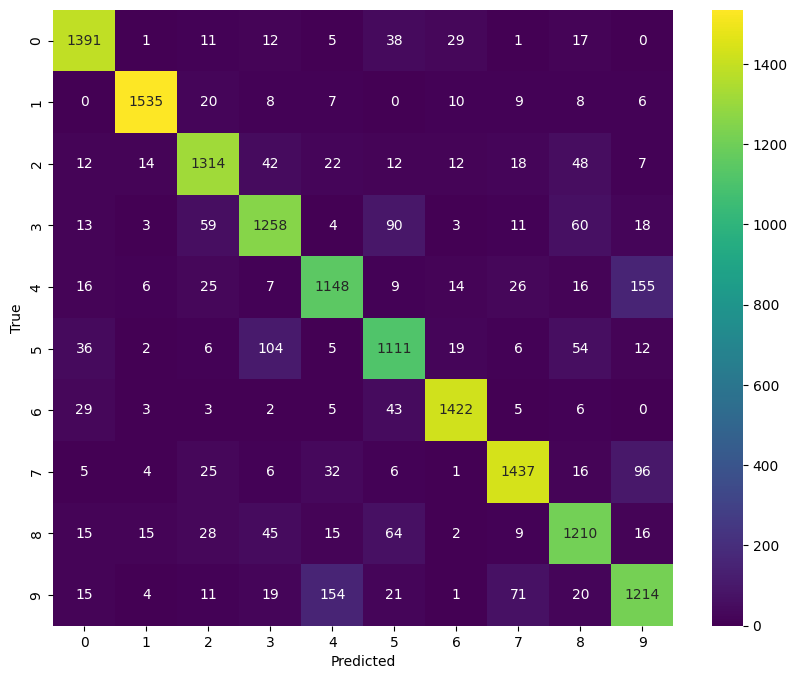

In [12]:
#####################################################
##  Calculate metrics and plot confusion matrix    ##
####################[Your Code]######################
x, y = next(iter(train_loader))
x = x.view(x.shape[0], -1)
x, y = x.to(device), y.to(device)
y_true = y.cpu().numpy()
y_pred = model.predict(x).cpu().numpy()
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

